In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
from Models.AutoEncoder import AutoEncoder, AE_validDataset, AE_trainDataset
from Models.DAGMM import *
from utils.utils import process_data
from utils.Visualization import plot_confusion_heatmap

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
num_epochs = 300
batch_size = 512
lr = 1e-4
encoding_dim = 28
n_gmm = 8
lambda_energy = 0.1
lambda_cov_diag = 0.005
l1_lambda = 1e-5

In [7]:
    cat_features = [
    'Gender',
    'Zipcode',
    'Day',
    'Card Brand',
    'Card Type',
    'Has Chip',
    'Whether Security Chip is Used',
    'Error Message',
    'WeekDay',
    'Credit Signal',
    'PIN Change',
    'Security Level'
]
num_features = [
    'Current Age',
    'Retirement Age',
    'Per Capita Income - Zipcode',
    'Yearly Income',
    'Total Debt',
    'Credit Score',
    'Valid Month',
    'Credit Limit',
    'Since Open Month',
    'Year PIN last Changed',
    'Amount',
    'Credit Util',
    'Years Changed PIN',
    'Security Score'
]
discarded = [
    'User',
    'Birth Year',
    'Birth Month',
    'Year',
    'Month',
    'Merchandise Code',
    'Card',
    'Card Number',
    'Expires',
    'Acct Open Date',
]

print(len(cat_features))
print(len(num_features))
print(len(discarded))
print(len(cat_features)*5 + len(num_features))

12
14
10
74


In [8]:

# 데이터 전처리
data_path = '../data/[24-2 DS_Project2] Data.csv'
(train_cat_X, train_num_X, train_y), (valid_cat_X, valid_num_X, valid_y), label_encoders, _ = process_data(
    data_path,
    cat_features,
    num_features,
    discarded
)

TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
UNLABEL
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


In [9]:
print(train_y.value_counts())
print(valid_y.value_counts())

Is Fraud?
0.0          733455
Name: count, dtype: int64
Is Fraud?
0.0          249722
1.0             358
Name: count, dtype: int64


In [10]:
train_dataset = AE_trainDataset(train_cat_X, train_num_X, device)
valid_dataset = AE_validDataset(valid_cat_X, valid_num_X, valid_y, device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [11]:
%load_ext autoreload
%autoreload 2
from Models.DAGMM import DAGMM

model = DAGMM(
    encoding_dim=encoding_dim,
    n_gmm=n_gmm,
    cat_features=cat_features,
    num_features=num_features,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.MSELoss()

checkpoint = torch.load('../Models/best_dagmm.pth')
model.load_state_dict(checkpoint)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\mose1\AppData\Local\Temp\ipykernel_9256\2635257466.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../Models/best_dagmm.pth')


<All keys matched successfully>

In [12]:
model.eval()
valid_loss = 0
reconstruction_errors = []
all_labels = []
total_recon_loss = 0  # Validation 복원 손실
total_energy_loss = 0  # Validation 에너지 손실

with torch.no_grad():
    for cat_features, num_features, labels in valid_loader:
        cat_features = cat_features.to(device)
        num_features = num_features.to(device)
        labels = labels.to(device)

        x, enc, dec, z, gamma = model(cat_features, num_features)

        # Validation 손실 계산
        loss, recon_loss, energy_loss, cov_diag_loss = model.loss(
            x, dec, z, gamma, lambda_energy, lambda_cov_diag
        )
        valid_loss += loss.mean().item()  # 총 Validation 손실 계산
        total_recon_loss += recon_loss.mean().item()
        total_energy_loss += energy_loss.mean().item()

        sample_errors = model.compute_energy(z, model.phi, model.mu, model.cov)
        reconstruction_errors.extend(sample_errors.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

# 손실 평균 계산
valid_loss /= len(valid_loader)
total_recon_loss /= len(valid_loader)
total_energy_loss /= len(valid_loader)

# Performance Evaluation
threshold = np.percentile(reconstruction_errors, 80)
print(reconstruction_errors)
predictions = (np.array(reconstruction_errors) > threshold).astype(int)
f1 = f1_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
precision = precision_score(all_labels, predictions, zero_division=1)

# 결과 출력
print(f"  Valid Loss     = {valid_loss:.4f}")
print(f"  Recon Loss     = {total_recon_loss:.4f}")
print(f"  Energy Loss    = {total_energy_loss:.4f}")
print(f"  Valid F1 Score = {f1:.4f}")
print(f"  Valid Recall   = {recall:.4f}")
print(f"  Valid Precision= {precision:.4f}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




  Valid Loss     = 1.2581
  Recon Loss     = 0.0073
  Energy Loss    = 11.8569
  Valid F1 Score = 0.0018
  Valid Recall   = 0.1257
  Valid Precision= 0.0009


Confusion Matrix:
 [[199753  49969]
 [   313     45]]


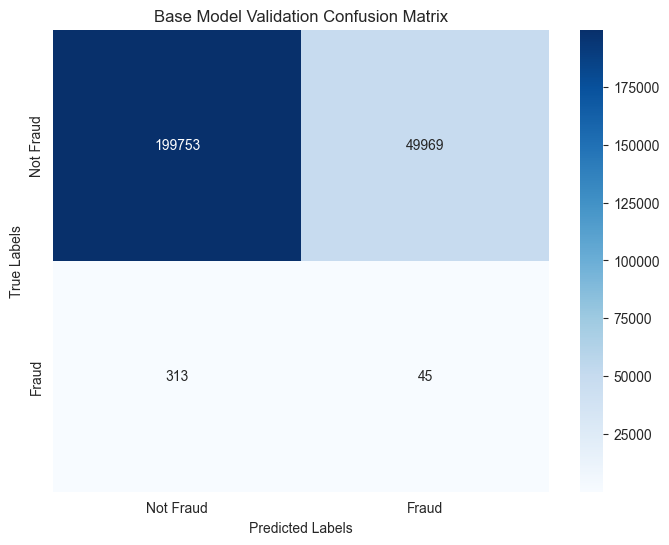

In [13]:
print("Confusion Matrix:\n", confusion_matrix(all_labels, predictions))
plot_confusion_heatmap(
    y_true=all_labels,
    y_pred=predictions,
    class_names=["Not Fraud", "Fraud"],
    title="Base Model Validation Confusion Matrix",
    cmap="Blues"
)